<a href="https://colab.research.google.com/github/skywalker0803r/oil_web/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90_modeling%E6%B5%81%E7%A8%8B_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install catboost
from google.colab import drive
drive.mount('/content/drive')
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import warnings;warnings.simplefilter('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_validate
from sklearn.linear_model import BayesianRidge, LinearRegression,Lasso,Ridge
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,max_error,make_scorer
from math import sqrt
from sklearn.manifold import isomap
from numpy import sqrt
import plotly.express as px
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.regressor import StackingCVRegressor
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# some function

In [0]:
def mape(a, b):
    a = np.array(a)
    b = np.array(b)
    mask = a != 0
    return (np.fabs(a-b)/a)[mask].mean()

def metric(y_t,y_p,name):
  res = {'R2' : max(r2_score(y_t,y_p), 0),
         'RMSE': sqrt(mean_squared_error(y_t,y_p)),
         'MAPE': mape(y_t,y_p)}
  return pd.DataFrame(res,index=[name])

# load data

In [3]:
data = pd.read_csv('/content/drive/My Drive/台塑輕油案子/data/test_250.csv',index_col=0)
train = data.loc[data.index %5 != 0]
test = data.loc[data.index %5 == 0]
test = test.drop(95,axis=0)
print(train.shape)
print(test.shape)

(200, 27)
(49, 27)


# select N+A >= 36

In [4]:
def select_NaddA(df):
  condition=(df['N+A']>=36)
  return df.loc[condition]
train = select_NaddA(train)
test = select_NaddA(test)
print(train.shape)
print(test.shape)

(182, 27)
(43, 27)


# 定義欄位

In [0]:
features = ['T10','T50','T90','N+A']
y_columns = ['C5NP', 'C5IP', 'C5N', 
             'C6NP', 'C6IP', 'C6N', 'C6A', 
             'C7NP', 'C7IP', 'C7N', 'C7A', 
             'C8NP', 'C8IP', 'C8N', 'C8A', 
             'C9NP', 'C9IP', 'C9N', 'C9A', 
             'C10NP', 'C10IP', 'C10N', 'C10A']

In [6]:
train = train[features+y_columns]
test = test[features+y_columns]
print(train.shape)
print(test.shape)

(182, 27)
(43, 27)


# gau

In [7]:
full = train.append(test)
gau = GaussianMixture(n_components=3)
gau.fit(full)
full['gau'] = gau.predict(full)
train = full[:200]
test = full[200:]
print(full.gau.value_counts())

1    127
0     64
2     34
Name: gau, dtype: int64


# 定義x,y

In [0]:
features.append('gau')
X_train = train[features]
X_test = test[features]
y_train = train[y_columns]
y_test = test[y_columns]

# 特徵縮放

In [0]:
#scaler_x = StandardScaler()
#X_train[:] = scaler_x.fit_transform(X_train[:])
#X_test[:] = scaler_x.transform(X_test[:])

# 降維萃取特徵

In [0]:
#for i,t in zip(['iso1','iso2','iso3'],['T10','T50','T90']):
#  iso = isomap.Isomap(n_components=1)
#  X_train[i] = iso.fit_transform(X_train[[t,'N+A']]) 
#  X_test[i] = iso.transform(X_test[[t,'N+A']]) 

# 產生溫差特徵

In [0]:
for df in [X_train,X_test]:
  df['T90-T50'] = df['T90']-df['T50']
  df['T50-T10'] = df['T50']-df['T10']
  df['T90-T10'] = df['T90']-df['T10']

# 平方特徵

In [0]:
#for df in [X_train,X_test]:
#  df['T10_s2'] = df['T10']**2
#  df['T50_s2'] = df['T50']**2
#  df['T90_s2'] = df['T90']**2
#  df['N+A_s2'] = df['N+A']**2

# 產生交互作用項

In [0]:
#from sklearn.preprocessing import PolynomialFeatures
#interaction = PolynomialFeatures(2, interaction_only=True, include_bias=False)
#X_train = interaction.fit_transform(X_train)
#X_train = pd.DataFrame(X_train,columns=interaction.get_feature_names())
#X_test = interaction.transform(X_test)
#X_test = pd.DataFrame(X_test,columns=interaction.get_feature_names())

# 特徵篩選

In [0]:
features = X_train.columns.tolist()
train = X_train.join(y_train)
test = X_test.join(y_test)
full = train.append(test)

def features_selected():
  features_map = {}
  for y_name in y_columns:
    best_feature = abs(full.corr(method='pearson')).loc[features,[y_name]].sort_values(by=y_name,ascending=False).index.tolist()[1:2]
    if best_feature not in ['T10','T50','T90','N+A']:
      features_map[y_name] =  ['T10','T50','T90','N+A'] + best_feature
    else:
      features_map[y_name] =  ['T10','T50','T90','N+A']
    features_map[y_name] =  ['T10','T50','T90','N+A']
  return features_map

In [15]:
features_map = features_selected()
res = pd.DataFrame()
for y_name in y_columns:
  res.loc[y_name,'features'] = str(features_map[y_name])
res

,features
C5NP,"['T10', 'T50', 'T90', 'N+A']"
C5IP,"['T10', 'T50', 'T90', 'N+A']"
C5N,"['T10', 'T50', 'T90', 'N+A']"
C6NP,"['T10', 'T50', 'T90', 'N+A']"
C6IP,"['T10', 'T50', 'T90', 'N+A']"
C6N,"['T10', 'T50', 'T90', 'N+A']"
C6A,"['T10', 'T50', 'T90', 'N+A']"
C7NP,"['T10', 'T50', 'T90', 'N+A']"
C7IP,"['T10', 'T50', 'T90', 'N+A']"
C7N,"['T10', 'T50', 'T90', 'N+A']"


# models

In [0]:
svr = Pipeline([('scaler',StandardScaler()),('regressor',SVR(C=15))])
cgb = CatBoostRegressor(n_estimators = 150,learning_rate = 0.1,verbose=False)
lr = Pipeline([('scaler',StandardScaler()),('regressor',LinearRegression())])
ridge = Pipeline([('scaler',StandardScaler()),('regressor',Ridge())])

# define model

# 測試

In [17]:
y_train_pred = pd.DataFrame(index = y_train.index,columns = y_columns)
y_pred = pd.DataFrame(index = y_test.index,columns = y_columns)

for y_name in y_columns:
  
  model = cgb
  model.fit(X_train[features_map[y_name]].values,y_train[y_name].values)

  y_train_pred[y_name] = model.predict(X_train[features_map[y_name]].values)
  y_pred[y_name] = model.predict(X_test[features_map[y_name]].values)

y_pred.head()  

,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
120,1.549703,0.966800,0.311392,3.164061,3.029270,6.233560,0.531941,5.284132,4.602074,18.864802,3.977431,6.810905,9.467944,9.431567,6.011422,3.894087,5.583244,4.016136,2.457773,1.080725,2.318767,0.401556,0.648081
125,1.660242,1.053518,0.326845,3.187458,3.002562,6.606814,0.545313,5.408867,4.493661,18.879985,3.381035,6.158134,9.746156,8.920281,5.242649,3.736907,5.585942,4.405009,2.430215,1.564757,2.897812,0.617889,1.119798
130,1.757421,1.140446,0.347078,3.212557,3.033792,6.581854,0.536705,5.315451,4.410801,18.723454,3.369930,6.180471,9.605873,9.110771,5.249566,3.760212,5.669775,4.360492,2.487429,1.352718,3.022864,0.516296,0.988057
135,0.930079,0.640588,0.223580,2.725927,2.343749,5.358676,0.589372,5.022999,4.765167,15.137259,3.839130,6.263794,8.227334,10.379699,5.989977,4.114307,7.459659,5.772949,3.222462,1.316830,3.841738,0.630141,1.019746
140,0.188281,0.111212,0.018479,0.727548,0.452701,5.992758,0.502954,6.618407,8.043594,28.134289,5.603656,4.996707,8.432114,9.287344,5.039328,1.931785,5.871430,4.322802,1.657006,0.443169,1.915734,0.428611,0.737259


In [18]:
res = pd.DataFrame()
for y_name in y_columns:
  res = res.append(metric(y_train[y_name],y_train_pred[y_name],y_name))
res.loc['AVG'] = res.mean()
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.996004,0.252547,0.476186
C5IP,0.996159,0.187893,0.826632
C5N,0.994514,0.024941,0.16947
C6NP,0.989756,0.205901,0.209107
C6IP,0.993709,0.212329,0.313158
C6N,0.97993,0.289186,0.0445552
C6A,0.979631,0.181037,0.262895
C7NP,0.968436,0.187285,0.0265743
C7IP,0.969034,0.261803,0.0368341
C7N,0.986092,0.666157,0.0381142


In [19]:
res = pd.DataFrame()
for y_name in y_columns:
  res = res.append(metric(y_test[y_name],y_pred[y_name],y_name))
res.loc['AVG'] = res.mean()
res.style.background_gradient()

,R2,RMSE,MAPE
C5NP,0.894938,0.646986,0.181496
C5IP,0.902325,0.329203,0.175745
C5N,0.870943,0.0546429,0.176971
C6NP,0.8703,0.465045,0.216604
C6IP,0.863366,0.49211,0.155746
C6N,0.679123,1.32842,0.199913
C6A,0.0322429,0.206374,0.487946
C7NP,0.687687,0.358005,0.0431979
C7IP,0.874023,0.5839,0.0648048
C7N,0.887621,1.51649,0.0592122


# loss analysis

In [0]:
y_name = 'C7N'

In [21]:
square_error = (y_pred[y_name]-y_test[y_name])**2
plot_data = pd.DataFrame()
plot_data[y_name] = y_test[y_name]
plot_data[y_name+'_pred'] = y_pred[y_name]
plot_data['loss'] = square_error
plot_data.sort_values(by='loss',ascending=False).head()

,C7N,C7N_pred,loss
145,17.906555,13.760428,17.190373
135,18.577741,15.137259,11.836920
200,14.437906,11.766543,7.136183
155,17.918637,15.386679,6.410809
120,20.558219,18.864802,2.867661


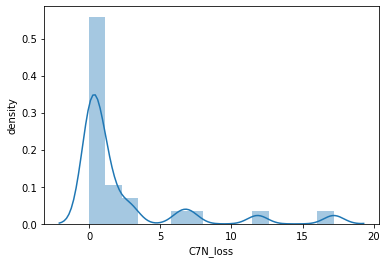

In [22]:
sns.distplot(square_error)
plt.xlabel(y_name+'_loss')
plt.ylabel('density')
plt.show()

Text(0, 0.5, 'square_error')

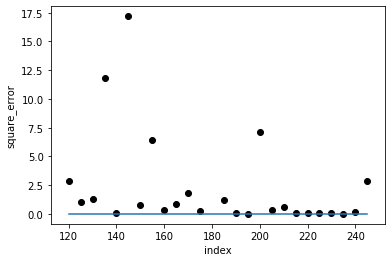

In [23]:
plt.plot(plot_data.index,[0 for i in range(len(plot_data))])
plt.scatter(plot_data.index,plot_data.loss,color='black')
plt.xlabel('index')
plt.ylabel('square_error')